In [ ]:
import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [ ]:
Path_data = '/content/drive/MyDrive/Dataset/Original_img'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/Dataset/Original_img/No_DR')
Mild = os.listdir('/content/drive/MyDrive/Dataset/Original_img/Mild')
Moderate = os.listdir('/content/drive/MyDrive/Dataset/Original_img/Moderate')
Proliferate = os.listdir('/content/drive/MyDrive/Dataset/Original_img/Proliferate_DR')
Severe = os.listdir('/content/drive/MyDrive/Dataset/Original_img/Severe')

In [ ]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")


classes names : ['Moderate', 'Proliferate_DR', 'Mild', 'Severe', 'No_DR', 'valid'] 
______________________________

Number of classes : 6 
______________________________

Number of Healty images : 325 
______________________________

Number of Mild images : 537 
______________________________

Number of Moderate images : 481 
______________________________

Number of Proliferate images : 358 
______________________________

Number of severe images : 315 
______________________________



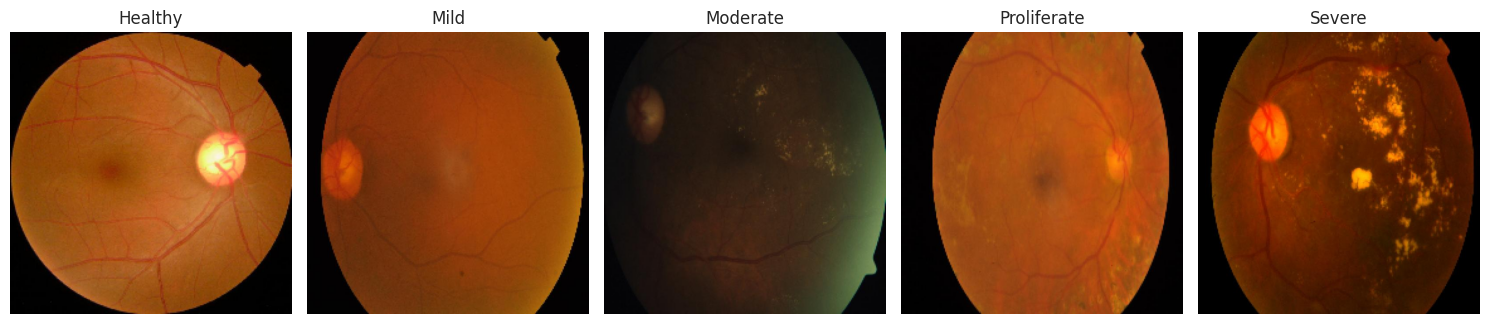

In [ ]:
No_DR = cv2.imread('/content/drive/MyDrive/Dataset/Original_img/No_DR/1-1-_png.rf.92f88af5ed7a558026571f0f88ffd2f4.jpg')
No_DR = cv2.cvtColor(No_DR, cv2.COLOR_BGR2RGB)
img1 = No_DR
Mild = cv2.imread('/content/drive/MyDrive/Dataset/Original_img/Mild/0024cdab0c1e_png.rf.ef17ddd625975b4745dff2abefe9d72a.jpg')
Mild = cv2.cvtColor(Mild, cv2.COLOR_BGR2RGB)
img2 = Mild
Mod = cv2.imread('/content/drive/MyDrive/Dataset/Original_img/Moderate/033f2b43de6d_png.rf.3af5ac19075f15d282bd07ee8b57256e.jpg')
Mod = cv2.cvtColor(Mod, cv2.COLOR_BGR2RGB)
img3 = Mod
pro = cv2.imread('/content/drive/MyDrive/Dataset/Original_img/Proliferate_DR/001639a390f0_png.rf.d7c6f3b95b92cb7a8706b0da9d58b04b.jpg')
pro = cv2.cvtColor(pro, cv2.COLOR_BGR2RGB)
img4 = pro
severe = cv2.imread('/content/drive/MyDrive/Dataset/Original_img/Severe/0104b032c141_png.rf.65bbb9f57a8e3feda2a8bc74f70aa272.jpg')
severe = cv2.cvtColor(severe, cv2.COLOR_BGR2RGB)
img5 = severe

plt.figure(figsize=(15,8))

plt.subplot(2,5,1)
plt.imshow(img1,cmap='gray')
plt.title("Healthy")
plt.axis("off")

plt.subplot(2,5,2)
plt.imshow(img2,cmap='gray')
plt.title("Mild")
plt.axis("off")

plt.subplot(2,5,3)
plt.imshow(img3,cmap='gray')
plt.title("Moderate")
plt.axis("off")

plt.subplot(2,5,4)
plt.imshow(img4,cmap='gray')
plt.title("Proliferate")
plt.axis("off")

plt.subplot(2,5,5)
plt.imshow(img5,cmap='gray')
plt.title("Severe")
plt.axis("off")

# Display the resized image
plt.tight_layout()
plt.show()


In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)

        return img

In [ ]:
def circle_crop(img, sigmaX=10):
    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.resize(img,(224,224))
    return img

In [ ]:
def grayscale(img):
    gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray_image

In [ ]:
def gabour(img):
    # Define the orientations you want to capture
    orientations = [0, np.pi/4, np.pi/2]  # Horizontal and diagonal orientations

    # Initialize an empty image with the same shape as the input
    filtered_img = np.zeros_like(img, dtype=np.float32)

    for theta in orientations:
        sigma = 1.99  # Standard deviation of the Gaussian envelope
        lambda_ = 9.8  # Wavelength of the sinusoidal factor
        gamma = 6.08  # Spatial aspect ratio
        phi = 0  # Phase offset

        # Generate Gabor filter
        gabor_kernel = cv2.getGaborKernel((21, 21), sigma, theta, lambda_, gamma, phi, ktype=cv2.CV_32F)

        # Apply Gabor filter and add it to the filtered image
        filtered_img += cv2.filter2D(img, cv2.CV_32F, gabor_kernel)  # Use CV_32F to keep precision

    # Scale the filtered image to the uint8 range
    filtered_img_scaled = (filtered_img - filtered_img.min()) / (filtered_img.max() - filtered_img.min()) * 255
    filtered_img_uint8 = np.clip(filtered_img_scaled, 0, 255).astype(np.uint8)

    return filtered_img_uint8

In [ ]:
# Ben graham method
def ben(img):
  sigmaX = 10
  img = crop_image_from_gray(img)
  img = cv2.resize(img, (224, 224))
  img =cv2.addWeighted (img,4, cv2.GaussianBlur( img , (0,0) ,sigmaX) ,-4 ,128)
  return img

In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):

    # Load the image
    image_org = cv2.imread(image_path)

    # converting default BGR to RGB format
    img1 = cv2.cvtColor(image_org, cv2.COLOR_BGR2RGB)

    #cropping the image
    img2 = circle_crop(img1)

    #converting to gray scale
    img3= grayscale(img2)

    # Using gabour filter
    img4= gabour(img3)

    #ben graham
    img5 = ben(img4)

    # Resize the image
    resized_image = cv2.resize(img5, target_size)

    # Normalize pixel values to the range [0, 1]
    normalized_image = resized_image.astype(np.float32) / 255.0

    return normalized_image

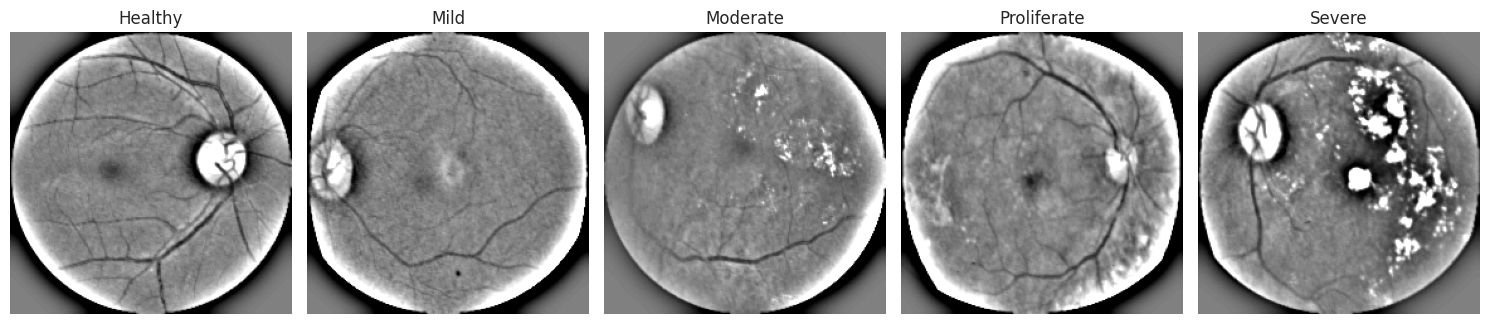

In [ ]:
No_DR_img = preprocess_image('/content/drive/MyDrive/Dataset/Original_img/No_DR/1-1-_png.rf.92f88af5ed7a558026571f0f88ffd2f4.jpg')
Mild_img = preprocess_image('/content/drive/MyDrive/Dataset/Original_img/Mild/0024cdab0c1e_png.rf.ef17ddd625975b4745dff2abefe9d72a.jpg')
Mod_img = preprocess_image('/content/drive/MyDrive/Dataset/Original_img/Moderate/033f2b43de6d_png.rf.3af5ac19075f15d282bd07ee8b57256e.jpg')
Pro_img = preprocess_image('/content/drive/MyDrive/Dataset/Original_img/Proliferate_DR/001639a390f0_png.rf.d7c6f3b95b92cb7a8706b0da9d58b04b.jpg')
Severe_img = preprocess_image('/content/drive/MyDrive/Dataset/Original_img/Severe/0104b032c141_png.rf.65bbb9f57a8e3feda2a8bc74f70aa272.jpg')

img_1 = No_DR_img
img_2 = Mild_img
img_3 = Mod_img
img_4 = Pro_img
img_5 = Severe_img

plt.figure(figsize=(15,8))

plt.subplot(2,5,1)
plt.imshow(img_1,cmap='gray')
plt.title("Healthy")
plt.axis("off")

plt.subplot(2,5,2)
plt.imshow(img_2,cmap='gray')
plt.title("Mild")
plt.axis("off")

plt.subplot(2,5,3)
plt.imshow(img_3,cmap='gray')
plt.title("Moderate")
plt.axis("off")

plt.subplot(2,5,4)
plt.imshow(img_4,cmap='gray')
plt.title("Proliferate")
plt.axis("off")

plt.subplot(2,5,5)
plt.imshow(img_5,cmap='gray')
plt.title("Severe")
plt.axis("off")

# Display the resized image
plt.tight_layout()
plt.show()

In [ ]:
Path_data = '/content/drive/MyDrive/Dataset/Process_img/Train_2'
data = os.listdir(Path_data)
Healthy = os.listdir('/content/drive/MyDrive/Dataset/Process_img/Train_2/No_DR')
Mild = os.listdir('/content/drive/MyDrive/Dataset/Process_img/Train_2/Mild')
Moderate = os.listdir('/content/drive/MyDrive/Dataset/Process_img/Train_2/Mod')
Proliferate = os.listdir('/content/drive/MyDrive/Dataset/Process_img/Train_2/Pro')
Severe = os.listdir('/content/drive/MyDrive/Dataset/Process_img/Train_2/Severe')

In [ ]:
# Get Paths

Path_data = '/content/drive/MyDrive/Dataset/Process_img/Train_2'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)

    for img in imglist:
        imgpath = os.path.join(classpath, img)

        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)



,Paths,Labels
0,/content/drive/MyDrive/Dataset/Process_img/Tra...,No_DR
1,/content/drive/MyDrive/Dataset/Process_img/Tra...,No_DR
2,/content/drive/MyDrive/Dataset/Process_img/Tra...,No_DR
3,/content/drive/MyDrive/Dataset/Process_img/Tra...,No_DR
4,/content/drive/MyDrive/Dataset/Process_img/Tra...,No_DR


In [ ]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (1612, 2)
Valid shape:  (202, 2)
Test shape:  (202, 2)


Labels
Mild      438
Mod       382
Pro       281
No_DR     258
Severe    253
Name: count, dtype: int64

In [ ]:
batch_size = 32   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 1612 validated image filenames belonging to 5 classes.
Found 202 validated image filenames belonging to 5 classes.
Found 202 validated image filenames belonging to 5 classes.


In [ ]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

43941136/43941136 [==============================] - 0s 0us/step


In [ ]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 1536)              0         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               786944    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
epochs = 30
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/30
51/51 [==============================] - 577s 10s/step - loss: 2.2755 - acc: 0.3524 - val_loss: 1.5855 - val_acc: 0.3515
Epoch 2/30
51/51 [==============================] - 37s 708ms/step - loss: 1.0864 - acc: 0.5316 - val_loss: 1.3089 - val_acc: 0.5099
Epoch 3/30
51/51 [==============================] - 36s 705ms/step - loss: 0.9346 - acc: 0.6234 - val_loss: 0.9492 - val_acc: 0.5842
Epoch 4/30
51/51 [==============================] - 36s 702ms/step - loss: 0.7530 - acc: 0.7053 - val_loss: 1.1584 - val_acc: 0.5149
Epoch 5/30
51/51 [==============================] - 36s 693ms/step - loss: 0.6762 - acc: 0.7289 - val_loss: 1.1342 - val_acc: 0.5594
Epoch 6/30
51/51 [==============================] - 37s 730ms/step - loss: 0.5365 - acc: 0.8033 - val_loss: 1.1275 - val_acc: 0.6436
Epoch 7/30
51/51 [==============================] - 36s 690ms/step - loss: 0.4968 - acc: 0.8040 - val_loss: 0.9177 - val_acc: 0.6931
Epoch 8/30
51/51 [==============================] - 36s 694ms/step - l

In [ ]:
#Accuracy and Loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


#Accuracy and Loss of Valid

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


#Highest value of Validation Accuracy by its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# Lowest value of Validation loss by index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


#Number of epochs based on length of Training Accuracy values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

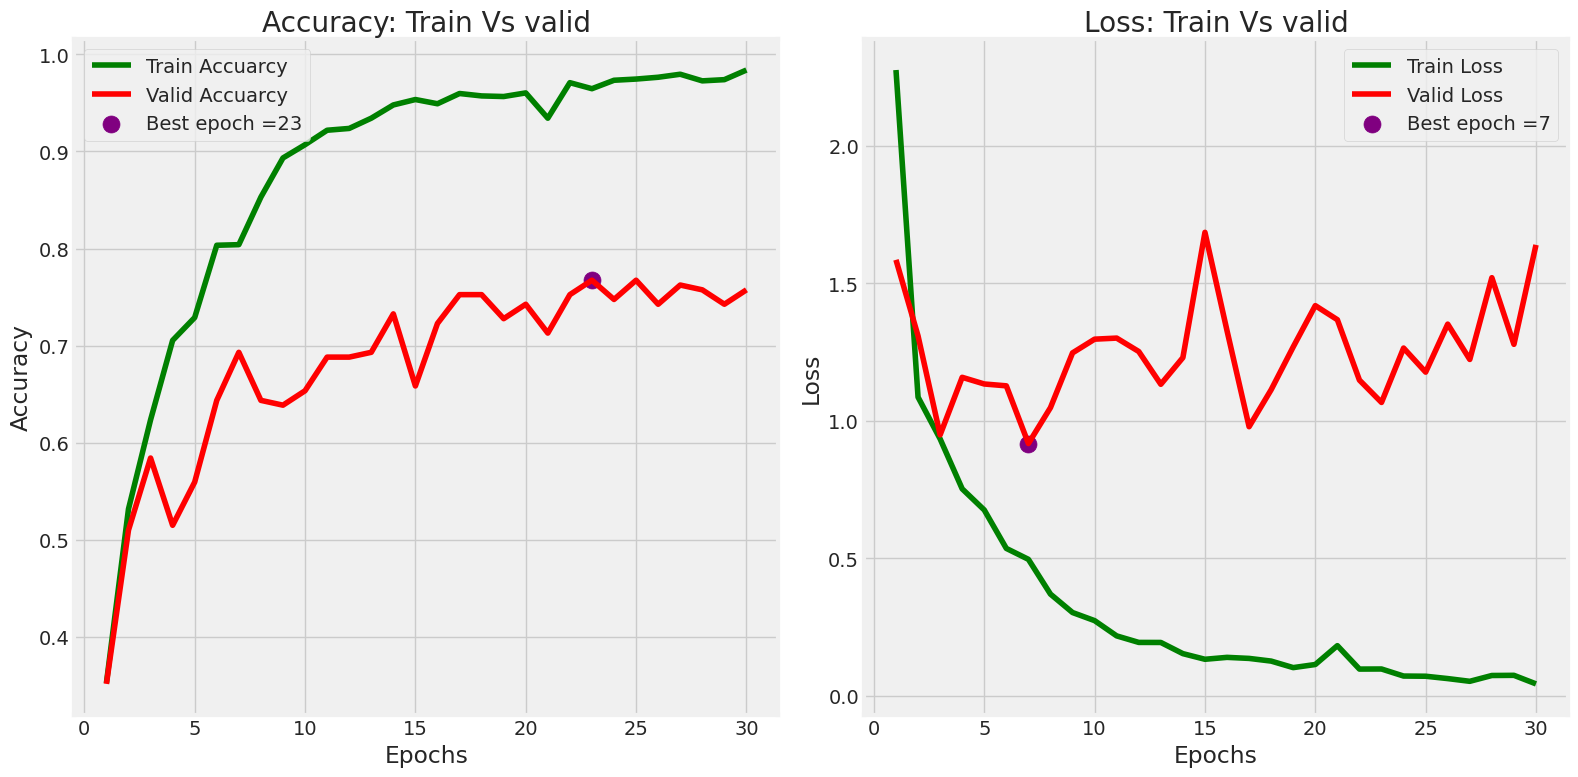

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)


print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

7/7 [==============================] - 45s 8s/step - loss: 1.1527 - acc: 0.7871
Train Scores : 
    accuracy: 0.996277928352356 
      Loss:  0.009799664840102196 
________________________
Valid Scores : 
    accuracy: 0.7574257254600525 
      Loss:  1.6398812532424927 
________________________
Test Scores : 
    accuracy: 0.7871286869049072 
      Loss:  1.152704119682312 
________________________


In [ ]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)


print(predictions)
print(y_pred)

[[9.4645878e-04 1.7743005e-06 9.9905175e-01 8.7280876e-09 6.1965438e-10]
 [1.5771351e-06 5.4857635e-05 9.9994361e-01 9.2248857e-09 5.4920757e-09]
 [1.7091068e-02 6.8098809e-05 9.8238271e-01 3.6951536e-04 8.8614703e-05]
 ...
 [4.0099397e-02 9.5958716e-01 1.8849079e-05 2.9207658e-04 2.4876504e-06]
 [2.7032396e-05 1.3860930e-02 1.1091105e-06 3.5561216e-03 9.8255485e-01]
 [6.7081445e-01 1.8411419e-07 3.2918519e-01 1.6701075e-07 1.0969216e-10]]
[2 2 2 0 4 2 3 4 0 3 1 1 1 4 4 0 4 2 2 1 1 3 2 0 0 3 0 2 0 4 0 4 0 0 0 2 2
 0 0 1 0 0 0 2 0 3 0 1 2 1 0 4 1 4 4 4 0 3 4 4 1 1 3 1 1 2 1 3 0 1 0 3 2 0
 0 0 3 1 0 1 1 0 1 0 0 1 4 2 4 0 0 0 0 0 0 0 1 3 2 4 2 0 0 0 0 1 4 3 4 1 0
 0 4 0 4 2 2 3 1 0 2 1 1 3 1 4 0 0 0 0 4 1 4 4 1 0 2 3 3 4 4 0 0 2 4 3 0 0
 3 1 0 0 3 4 0 3 4 4 0 1 1 4 3 0 4 2 0 1 4 4 1 4 0 4 2 0 0 0 4 1 2 4 3 1 2
 1 0 1 4 0 1 0 3 4 2 0 0 0 0 1 4 0]


In [ ]:
#Use number of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

#Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[49,  0,  1,  0,  2],
       [ 9, 35,  0,  3,  5],
       [ 5,  0, 26,  0,  0],
       [ 8,  2,  0, 20,  5],
       [ 0,  3,  0,  0, 29]])

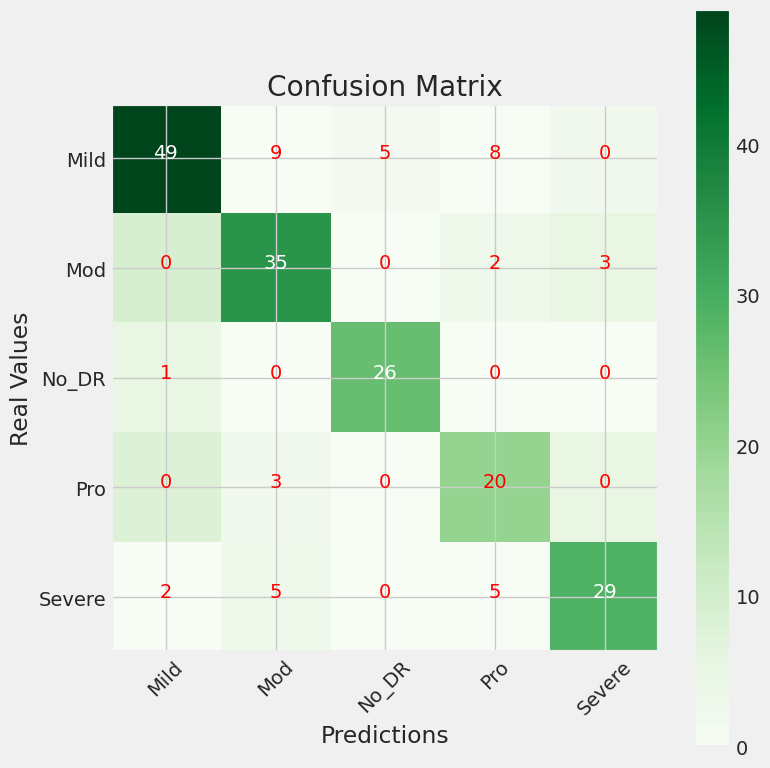

In [ ]:
# Confusion matrix visualization
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
#Calssification of precision, recall, f1-score, support
print(classification_report(Test.classes, y_pred, target_names = classes))

              precision    recall  f1-score   support

        Mild       0.69      0.94      0.80        52
         Mod       0.88      0.67      0.76        52
       No_DR       0.96      0.84      0.90        31
         Pro       0.87      0.57      0.69        35
      Severe       0.71      0.91      0.79        32

    accuracy                           0.79       202
   macro avg       0.82      0.79      0.79       202
weighted avg       0.81      0.79      0.78       202



In [ ]:
# Save the model architecture as JSON
model_json = model.to_json()
with open("DR_efficientNet_architecture.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:
# Save the model weights (parameters) separately in HDF5 format
model.save_weights("DR_efficientNet_weights.h5")


In [ ]:
model.save('DR efficientNet.h5')

In [ ]:
save_path = '/content/drive/MyDrive/ML Models/DR_efficientNet.h5'
model.save(save_path)